In [30]:
import sys
sys.path.insert(0, "/home/gstupp/projects/metaproteomics")

In [31]:
import os
import requests
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
from glob import glob
import numpy as np
from itertools import chain
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [32]:
from metaproteomics.file_processing.blazmass_tools import dta_select_parser, build_pep_quant_dict
from metaproteomics.goatools import obo_parser
goa = obo_parser.GODag()

load obo file /home/gstupp/projects/metaproteomics/metaproteomics/goatools/go-basic.obo
48437 nodes imported


In [33]:
files = glob("data/*/*/*.txt")

In [34]:
files

['data/PA/Pellet/PA pellet 2.txt',
 'data/PA/Pellet/PA pellet 3.txt',
 'data/PA/Pellet/PA pellet 1.txt',
 'data/PA/Triflic/PA triflic 2.txt',
 'data/PA/Triflic/PA triflic 3.txt',
 'data/PA/Triflic/PA triflic 1.txt',
 'data/PA/Sonic/PA sonic 1.txt',
 'data/PA/Sonic/PA sonic 3.txt',
 'data/PA/Sonic/PA sonic 2.txt',
 'data/Jurkat/Triflic/Jurkat triflic 1.txt',
 'data/Jurkat/Triflic/Jurkat triflic 2.txt',
 'data/Jurkat/Triflic/Jurkat triflic 3.txt',
 'data/Jurkat/Sonic/Jurkat sonic 1.txt',
 'data/Jurkat/Sonic/Jurkat sonic 3.txt',
 'data/Jurkat/Sonic/Jurkat sonic 2.txt',
 'data/BS/Pellet/BS pellet 3.txt',
 'data/BS/Pellet/BS pellet 2.txt',
 'data/BS/Pellet/BS pellet 1.txt',
 'data/BS/Triflic/BS triflic 3.txt',
 'data/BS/Triflic/BS triflic 1.txt',
 'data/BS/Triflic/BS triflic 2.txt',
 'data/BS/Sonic/BS sonic 1.txt',
 'data/BS/Sonic/BS sonic 3.txt',
 'data/BS/Sonic/BS sonic 2.txt']

In [35]:
df = pd.read_csv("annotations.mapped.gaf", sep="\t", comment="!", header=None)
df = df.rename(columns={1:"id", 4:"go_id", 8:'aspect'})
#df = df.query("go_id != 'GO:0005575'")  # remove 'cellular component'
df.head(2)

,0,id,2,3,go_id,5,6,7,aspect,9,10,11,12,13,14,15,16
0,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0071944,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN
1,UniProtKB,A0A024R161,DNAJC25-GNG10,NaN,GO:0016020,GO_REF:0000002,IEA,InterPro:IPR001770|InterPro:IPR015898,C,Guanine nucleotide-binding protein subunit gamma,A0A024R161_HUMAN|hCG_1994888,protein,taxon:9606,20170603,InterPro,NaN,NaN


In [36]:
# sanity check, show all annotations
print(', '.join({goa[x].name: x for x in set(df['go_id'])}))

cytoplasm, membrane, cell, organelle, cellular_component, cell periphery


In [37]:
gb = df.groupby("id").agg({'go_id': lambda x: ','.join(x)})
annots = {k:v.split(",") for k,v in dict(zip(gb.index,gb.go_id)).items()}

In [38]:
len(annots)

23385

In [39]:
def get_proteins(loci):
    loci = [x for x in loci['loci'] if "|" in x['description']]
    for locus in loci:
        locus['uniprot'] = locus['description'].split("|")[1]
    return loci
locus = next(dta_select_parser(files[9], return_reverse=False))
get_proteins(locus)

[{'Descriptive Name': 'Tubulin alpha-1B chain (Fragment) OS=Homo sapiens GN=TUBA1B PE=1 SV=1 ',
  'EMPAI': 4.1760683,
  'Length': 49,
  'Locus': 0,
  'MolWt': 5319,
  'NSAF': 0.003459728,
  'Sequence Count': 3,
  'Sequence Coverage': 0.7140000000000001,
  'Spectrum Count': 10,
  'Validation Status': 'U',
  'description': 'tr|F8VRK0|F8VRK0_HUMAN',
  'pI': 4.9,
  'reverse': False,
  'uniprot': 'F8VRK0'}]

In [40]:
proteins = dict()
for file in files:
    uniprot = set(chain(*[[x['uniprot'] for x in get_proteins(locus)] for locus in dta_select_parser(file, return_reverse=False)]))
    proteins[file] = uniprot

{k:len(v) for k,v in proteins.items()}

{'data/BS/Pellet/BS pellet 1.txt': 804,
 'data/BS/Pellet/BS pellet 2.txt': 892,
 'data/BS/Pellet/BS pellet 3.txt': 975,
 'data/BS/Sonic/BS sonic 1.txt': 906,
 'data/BS/Sonic/BS sonic 2.txt': 902,
 'data/BS/Sonic/BS sonic 3.txt': 912,
 'data/BS/Triflic/BS triflic 1.txt': 900,
 'data/BS/Triflic/BS triflic 2.txt': 966,
 'data/BS/Triflic/BS triflic 3.txt': 1142,
 'data/Jurkat/Sonic/Jurkat sonic 1.txt': 4129,
 'data/Jurkat/Sonic/Jurkat sonic 2.txt': 2116,
 'data/Jurkat/Sonic/Jurkat sonic 3.txt': 3527,
 'data/Jurkat/Triflic/Jurkat triflic 1.txt': 2466,
 'data/Jurkat/Triflic/Jurkat triflic 2.txt': 2382,
 'data/Jurkat/Triflic/Jurkat triflic 3.txt': 2541,
 'data/PA/Pellet/PA pellet 1.txt': 1334,
 'data/PA/Pellet/PA pellet 2.txt': 1220,
 'data/PA/Pellet/PA pellet 3.txt': 1277,
 'data/PA/Sonic/PA sonic 1.txt': 1442,
 'data/PA/Sonic/PA sonic 2.txt': 1146,
 'data/PA/Sonic/PA sonic 3.txt': 945,
 'data/PA/Triflic/PA triflic 1.txt': 1167,
 'data/PA/Triflic/PA triflic 2.txt': 1380,
 'data/PA/Triflic/PA

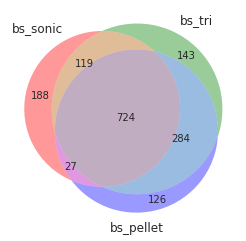

In [63]:
from matplotlib_venn import venn2, venn3
%matplotlib inline
bs_sonic = proteins['data/BS/Sonic/BS sonic 1.txt'] | proteins['data/BS/Sonic/BS sonic 2.txt'] | proteins['data/BS/Sonic/BS sonic 3.txt'] 
bs_tri = proteins['data/BS/Triflic/BS triflic 1.txt'] | proteins['data/BS/Triflic/BS triflic 2.txt'] | proteins['data/BS/Triflic/BS triflic 3.txt'] 
bs_pellet = proteins['data/BS/Pellet/BS pellet 1.txt'] | proteins['data/BS/Pellet/BS pellet 2.txt'] | proteins['data/BS/Pellet/BS pellet 3.txt'] 
venn3([bs_sonic, bs_tri, bs_pellet], ['bs_sonic', 'bs_tri', 'bs_pellet'])

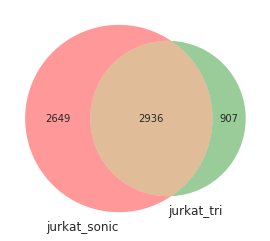

In [42]:
jurkat_sonic = proteins['data/Jurkat/Sonic/Jurkat sonic 1.txt'] | proteins['data/Jurkat/Sonic/Jurkat sonic 2.txt'] | proteins['data/Jurkat/Sonic/Jurkat sonic 3.txt'] 
jurkat_tri = proteins['data/Jurkat/Triflic/Jurkat triflic 1.txt'] | proteins['data/Jurkat/Triflic/Jurkat triflic 2.txt'] | proteins['data/Jurkat/Triflic/Jurkat triflic 3.txt'] 
venn2([jurkat_sonic, jurkat_tri], ['jurkat_sonic', 'jurkat_tri'])

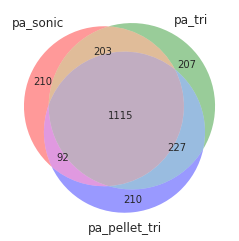

In [43]:
pa_sonic = proteins['data/PA/Sonic/PA sonic 1.txt'] | proteins['data/PA/Sonic/PA sonic 2.txt'] | proteins['data/PA/Sonic/PA sonic 3.txt'] 
pa_tri = proteins['data/PA/Triflic/PA triflic 1.txt'] | proteins['data/PA/Triflic/PA triflic 2.txt'] | proteins['data/PA/Triflic/PA triflic 3.txt'] 
pa_pellet_tri = proteins['data/PA/Pellet/PA pellet 1.txt'] | proteins['data/PA/Pellet/PA pellet 2.txt'] | proteins['data/PA/Pellet/PA pellet 3.txt'] 
venn3([pa_sonic, pa_tri, pa_pellet_tri], ['pa_sonic', 'pa_tri', 'pa_pellet_tri'])

In [44]:
def get_go_count(file):
    """
    If a locus has multiple proteins, the go annotations for each protein are used and the spectral count assigned
    is divided by the number of proteins in the locus.
    If a protein has multiple go terms, the spectral count for that protein is divided by the number of GO terms
    """
    descr = dict()
    d = defaultdict(int)
    for locus in dta_select_parser(file, return_reverse=False):
        proteins = get_proteins(locus)
        for p in proteins:
            this_go = annots.get(p['uniprot'], [])
            descr[p['uniprot']] = {'go': ";".join(this_go), 'q': locus['quantification'], 
                          'go_name': ";".join([goa[x].name for x in this_go]), 
                          'name': p['Descriptive Name']}
            for go in this_go:
                c = (locus['quantification']/len(proteins))/len(this_go)
                d[go]+=c
            if not this_go:
                d['unknown']+=locus['quantification']/len(proteins)
    d = dict(d)
    return d, descr

d,p = get_go_count(files[12])
d

{'GO:0005575': 1267.6147380516054,
 'GO:0005623': 5517.775782093927,
 'GO:0005737': 5974.558873821577,
 'GO:0016020': 1866.744554711019,
 'GO:0043226': 7937.1236850392515,
 'GO:0071944': 1189.4716519972055,
 'unknown': 22995.710714285797}

In [64]:
def get_membrane_count(d):
    # cell periphery + membrane + organelle == membrane
    membrane = {'GO:0071944', 'GO:0016020', 'GO:0043226'}
    membrane_count = sum(count for go,count in d.items() if go in membrane)
    not_membrane_count = sum(count for go,count in d.items() if go not in membrane and go!="unknown")
    return membrane_count, not_membrane_count

In [65]:
counts = dict()
all_counts = dict()
for file in tqdm(files):
    d,p = get_go_count(file)
    all_counts[file] = {goa[k].name if k!="unknown" else "unknown":v for k,v in d.items()}
    membrane_count, not_membrane_count = get_membrane_count(d)
    counts[file] = (membrane_count, not_membrane_count, np.log(membrane_count/not_membrane_count))
    pd.DataFrame(p).T.to_csv(file + "_go_counts.csv")

100%|██████████| 24/24 [00:06<00:00,  3.88it/s]


In [66]:
df_out = pd.DataFrame({'files': list(counts.keys()),
 'membrane': [x[0] for x in counts.values()],
 'non-membrane': [x[1] for x in counts.values()],
 'ratio': [x[2] for x in counts.values()],
 'method': ["sonic" if "sonic" in file else "tri" for file in counts],
 'pellet': ["pellet" in file.lower() for file in counts],
 'cell': [file.split("/")[1] for file in counts]})
df_out = df_out.sort_values(["cell", "method"])
df_out

,cell,files,membrane,method,non-membrane,pellet,ratio
10,BS,data/BS/Sonic/BS sonic 1.txt,2985.767466,sonic,16658.232534,False,-1.719048
15,BS,data/BS/Sonic/BS sonic 3.txt,2721.505667,sonic,15688.494333,False,-1.751742
16,BS,data/BS/Sonic/BS sonic 2.txt,2624.988828,sonic,15031.011172,False,-1.745039
3,BS,data/BS/Pellet/BS pellet 2.txt,5116.176707,tri,42418.823293,True,-2.115185
5,BS,data/BS/Pellet/BS pellet 1.txt,5722.964072,tri,51368.035928,True,-2.194529
6,BS,data/BS/Pellet/BS pellet 3.txt,4264.003066,tri,29390.996934,True,-1.930480
7,BS,data/BS/Triflic/BS triflic 2.txt,3600.798948,tri,22052.201052,False,-1.812257
9,BS,data/BS/Triflic/BS triflic 1.txt,2731.536908,tri,13811.463092,False,-1.620634
20,BS,data/BS/Triflic/BS triflic 3.txt,5098.263434,tri,28442.736566,False,-1.718993
4,Jurkat,data/Jurkat/Sonic/Jurkat sonic 2.txt,11159.490805,sonic,14893.223372,False,-0.288616


In [67]:
df_out.to_csv("df_out.csv")

In [68]:
%matplotlib inline

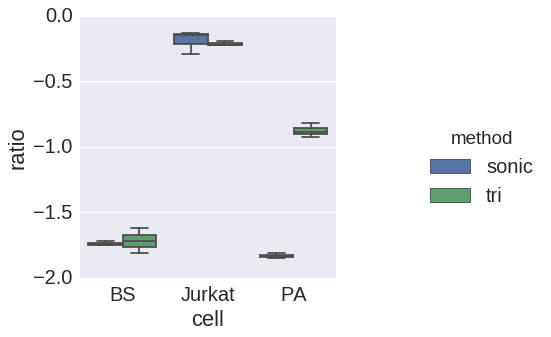

In [71]:
import seaborn as sns
sns.set(font_scale=2)
g = sns.factorplot(x="cell", y="ratio", hue="method", data=df_out.query("not pellet"), kind="box")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

In [72]:
all_counts = pd.DataFrame(all_counts)

In [73]:
all_counts = all_counts.T
all_counts.index = all_counts.index.map(lambda x:x.split("/")[-1].split(".")[0])
all_counts.to_csv("all_counts.csv")
all_counts

,cell,cell periphery,cellular_component,cytoplasm,membrane,organelle,unknown
BS pellet 1,10071.478713,1899.310057,1617.325758,39679.231457,1360.769456,2462.884560,14566.000000
BS pellet 2,7985.291972,1385.027312,1327.778105,33105.753216,1570.517641,2160.631754,13539.000000
BS pellet 3,5078.966520,1170.788869,830.748762,23481.281652,1803.131618,1290.082579,12074.000000
BS sonic 1,3388.666467,856.894969,706.353696,12563.212371,1632.760831,496.111666,10844.000000
BS sonic 2,3623.425566,751.657651,576.092280,10831.493326,1423.322627,450.008550,10101.000000
BS sonic 3,3124.933783,772.912690,733.015374,11830.545177,1506.045413,442.547564,10572.000000
BS triflic 1,2282.739019,739.310706,452.237185,11076.486888,1223.106530,769.119672,7791.000000
BS triflic 2,3569.810281,1018.303877,774.757986,17707.632784,1770.308486,812.186586,10025.000000
BS triflic 3,5106.884091,1378.754024,1025.834471,22310.018004,2195.082332,1524.427078,13478.000000
Jurkat sonic 1,5517.775782,1189.471652,1267.614738,5974.558874,1866.744555,7937.123685,22995.710714


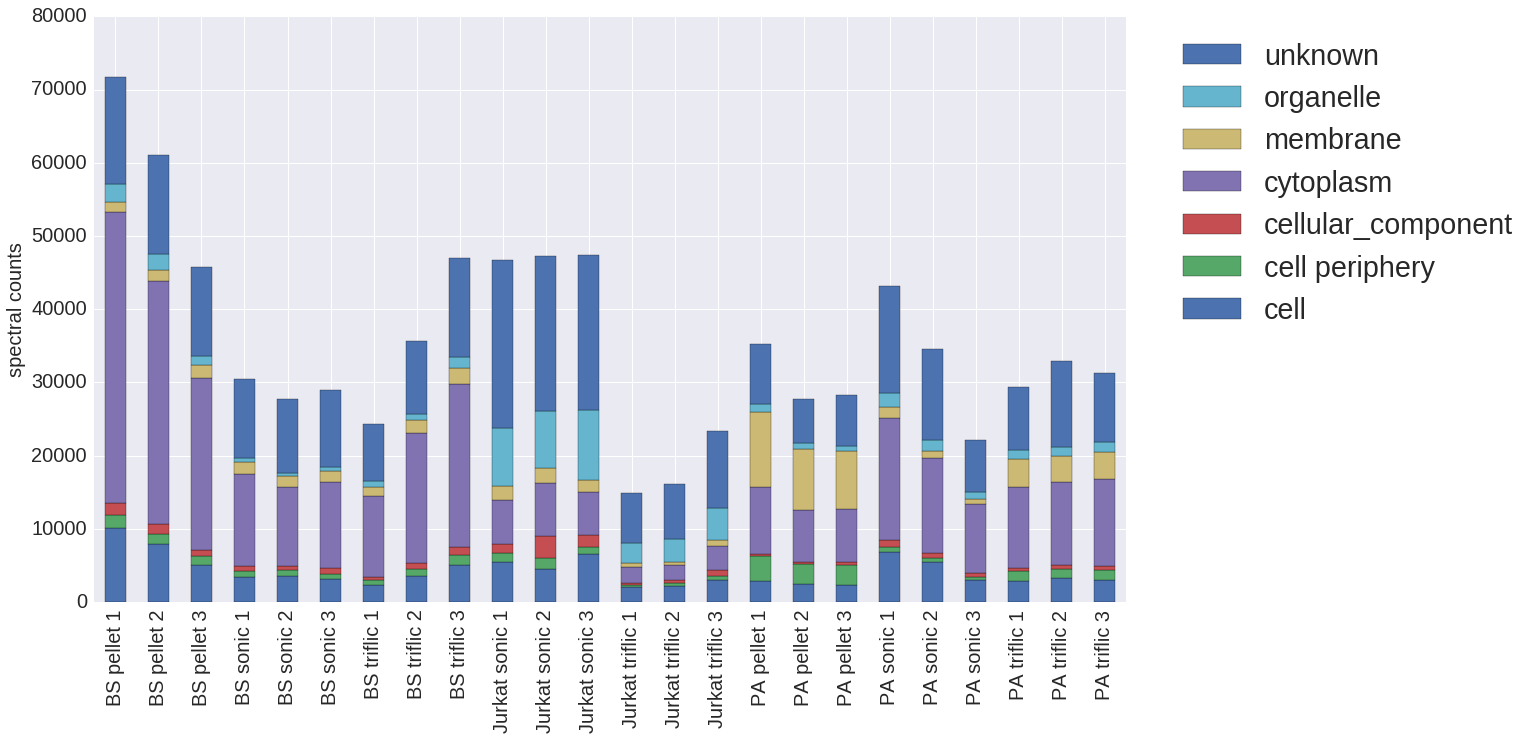

In [74]:
ax = all_counts.plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)

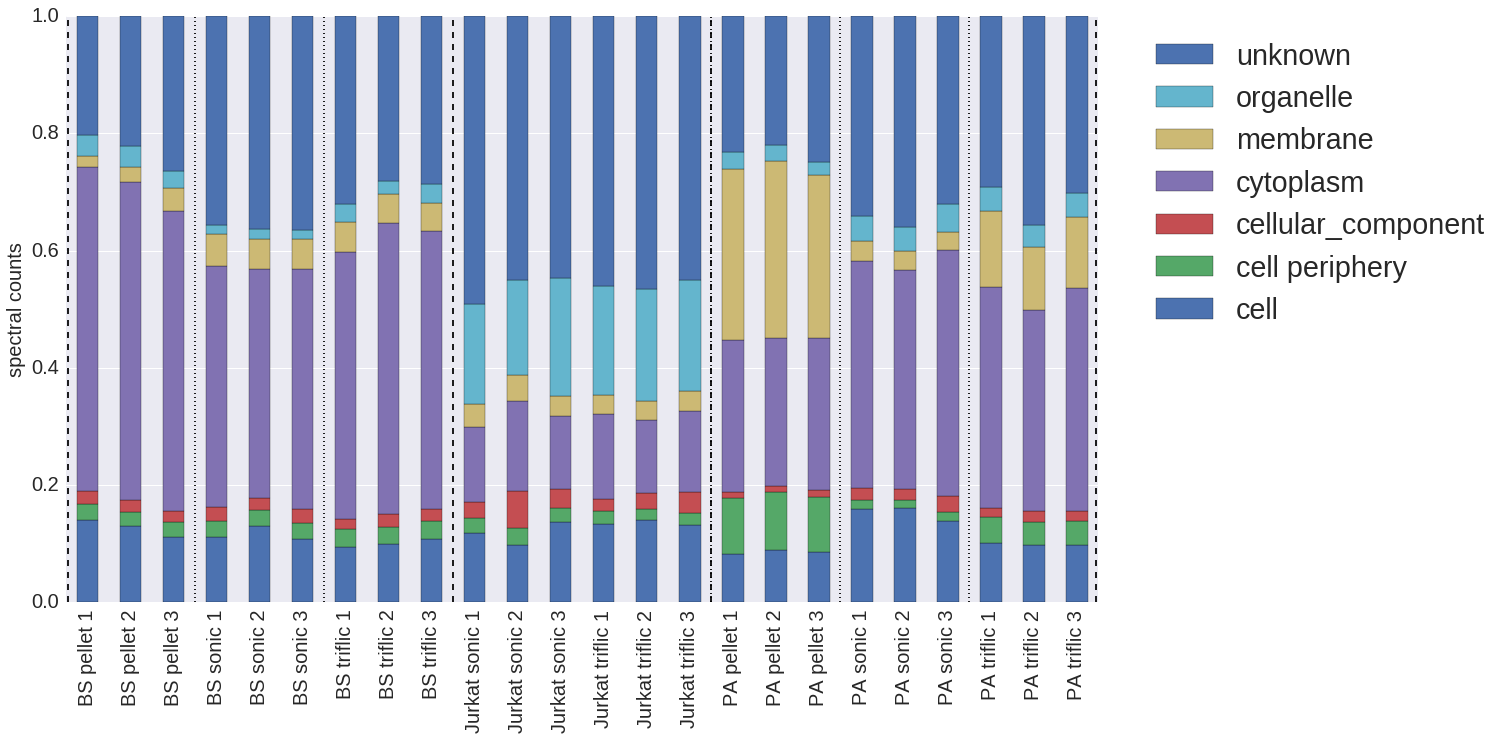

In [82]:
ax = all_counts.div(all_counts.sum(1), axis=0).plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
ax.set_ylim(0,1)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=-0.45, linestyle='--', color='k')
ax.axvline(x=8.5, linestyle='--', color='k')
ax.axvline(x=14.5, linestyle='--', color='k')
ax.axvline(x=23.45, linestyle='--', color='k')
ax.axvline(x=2.5, linestyle=':', color='k')
ax.axvline(x=5.5, linestyle=':', color='k')
ax.axvline(x=14.5, linestyle=':', color='k')
ax.axvline(x=17.5, linestyle=':', color='k')
ax.axvline(x=20.5, linestyle=':', color='k')

In [83]:
df = all_counts.T
gs = ["BS sonic", "BS triflic", "BS pellet", "Jurkat sonic", "Jurkat triflic", "PA sonic", "PA triflic", "PA pellet"]
for g in gs:
    df[g] = df[df.columns[df.columns.str.contains(g)]].sum(1)
df = df[gs]
df3 = df.T

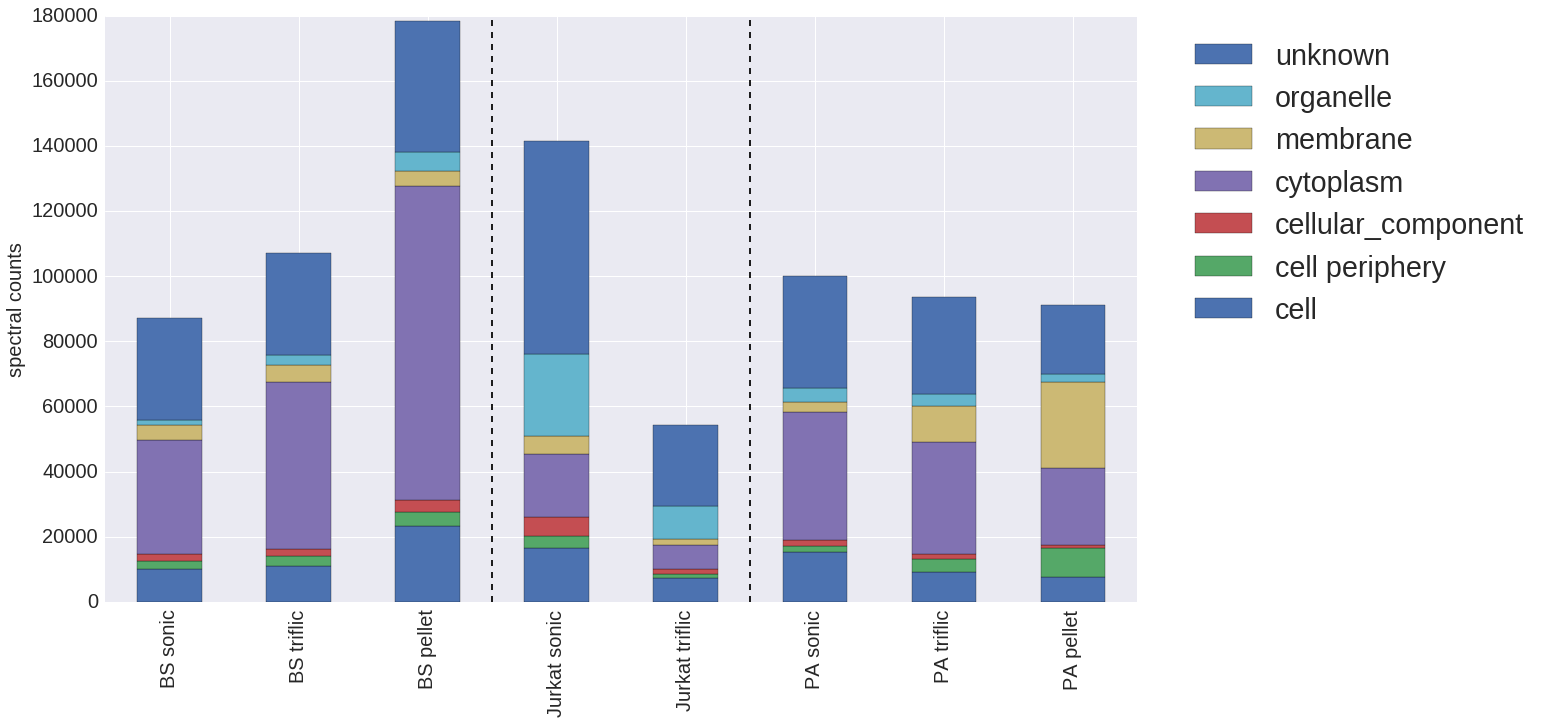

In [84]:
ax = df3.plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=2.5, linestyle='--', color='k')
ax.axvline(x=4.5, linestyle='--', color='k')

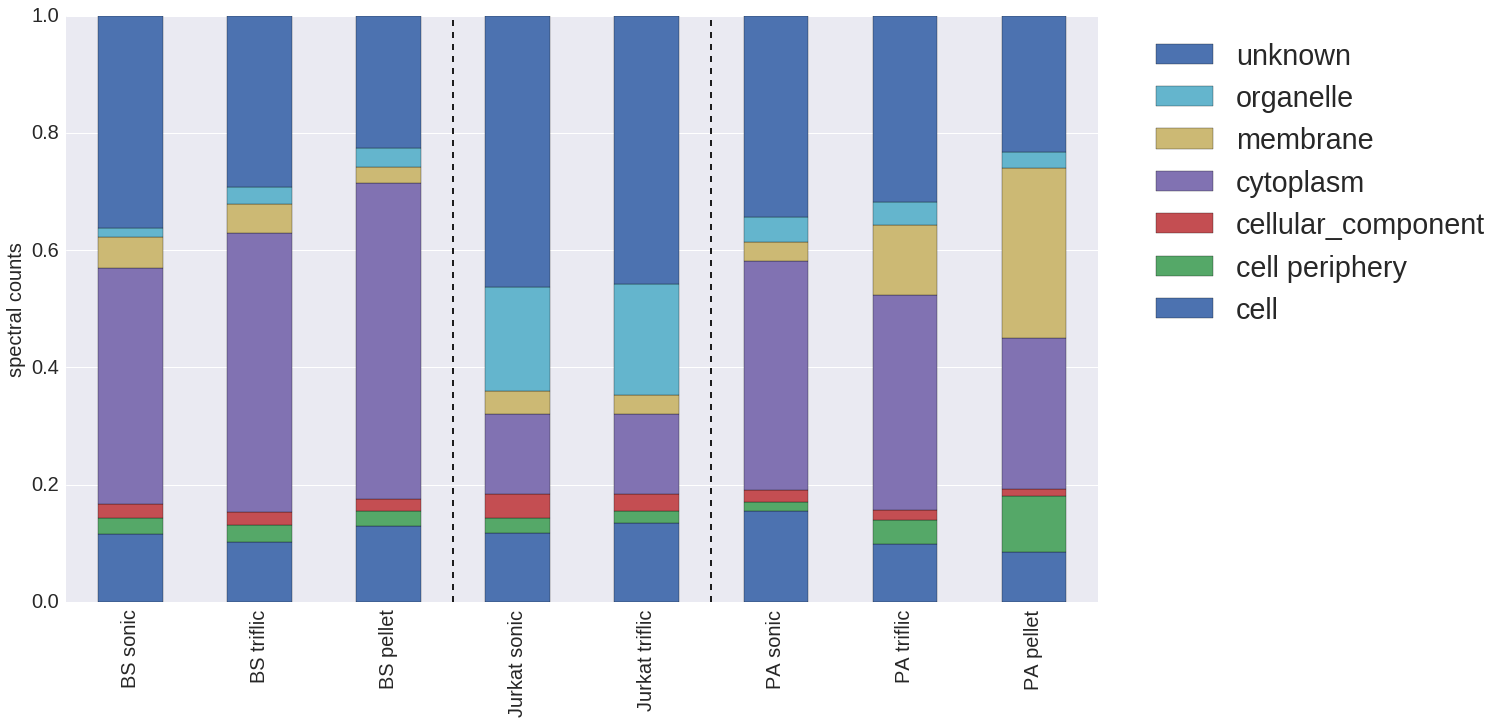

In [85]:
ax = df3.div(df3.sum(1), axis=0).plot.bar(stacked=True, legend=False)
ax.set_ylabel("spectral counts")
ax.set_ylim(0,1)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches[::-1], labels[::-1], bbox_to_anchor=(1.4, 1), fontsize='large')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.axvline(x=2.5, linestyle='--', color='k')
ax.axvline(x=4.5, linestyle='--', color='k')